### Calculate the metrics

1. F1
2. Mean IoU
3. Recall
4. Precision
5. Accuracy

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.metrics import f1_score, jaccard_score, recall_score, precision_score, accuracy_score

### Load predict mask and ground truth mask

In [3]:
# Paths to predicted masks and ground truth masks
pred_mask_dir = "/home/ahsan/University/Thesis/UNet_Directory/Datasets/second_phase/predicted_masks/ResUnet"
true_mask_dir = "/home/ahsan/University/Thesis/UNet_Directory/Datasets/second_phase/processed_dataset/aug/test/masks"

In [4]:
# Load mask file paths
pred_mask_paths = sorted(glob(os.path.join(pred_mask_dir, "*.png")))
true_mask_paths = sorted(glob(os.path.join(true_mask_dir, "*.png")))

# Ensure equal number of files
assert len(pred_mask_paths) == len(true_mask_paths), "Mismatch in predicted and ground truth mask counts."

### Calculate the metrics

In [5]:
# Updated class mappings for grayscale values
CLASS_MAPPING = {0: 0, 128: 1, 255: 2}
VALID_VALUES = np.array([0, 128, 255])  # Expected grayscale values

# Function to convert grayscale values to class indices
def convert_mask(mask):
    mask_converted = np.zeros_like(mask, dtype=np.uint8)
    for gray_value, class_id in CLASS_MAPPING.items():
        mask_converted[mask == gray_value] = class_id
    return mask_converted

# Initialize metrics
scores = []

# Metrics Calculation
for pred_path, true_path in tqdm(zip(pred_mask_paths, true_mask_paths), total=len(pred_mask_paths), desc="Evaluating ResU-Net"):
    # Load predicted and true masks
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    true_mask = cv2.imread(true_path, cv2.IMREAD_GRAYSCALE)

    if pred_mask is None or true_mask is None:
        print(f"Skipping {pred_path} or {true_path} due to loading error.")
        continue

    # Validate mask values
    if not np.all(np.isin(np.unique(pred_mask), VALID_VALUES)) or not np.all(np.isin(np.unique(true_mask), VALID_VALUES)):
        print(f"Unexpected values in {pred_path} or {true_path}. Skipping...")
        continue

    # Convert grayscale mask values to class indices (0, 1, 2)
    pred_mask = convert_mask(pred_mask).flatten().astype(np.int32)
    true_mask = convert_mask(true_mask).flatten().astype(np.int32)

    # Calculate metrics
    acc = accuracy_score(true_mask, pred_mask)
    f1 = f1_score(true_mask, pred_mask, average="macro", labels=[0, 1, 2])
    iou = jaccard_score(true_mask, pred_mask, average="macro", labels=[0, 1, 2])
    recall = recall_score(true_mask, pred_mask, average="macro", labels=[0, 1, 2])
    precision = precision_score(true_mask, pred_mask, average="macro", labels=[0, 1, 2])

    # Append metrics
    scores.append([os.path.basename(pred_path), acc, f1, iou, recall, precision])

# Check if any valid scores were collected
if len(scores) == 0:
    print("No valid masks evaluated.")
    exit()

Evaluating ResU-Net:  68%|██████▊   | 13/19 [00:21<00:09,  1.62s/it]/home/ahsan/PortableApps/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Evaluating ResU-Net:  74%|███████▎  | 14/19 [00:22<00:08,  1.62s/it]/home/ahsan/PortableApps/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Evaluating ResU-Net: 100%|██████████| 19/19 [00:30<00:00,  1.63s/it]


In [6]:
# Convert to numpy array for mean calculation
scores_np = np.array([s[1:] for s in scores])

In [7]:
mean_scores = np.mean(scores_np, axis=0)


In [8]:
# Print Metrics
# print(f"Mean Accuracy: {mean_scores[0]:0.5f}")
# print(f"Mean F1 Score: {mean_scores[1]:0.5f}")
# print(f"Mean IoU: {mean_scores[2]:0.5f}")
# print(f"Mean Recall: {mean_scores[3]:0.5f}")
# print(f"Mean Precision: {mean_scores[4]:0.5f}")

# Print Metrics
print(f"ResU-Net Mean Accuracy: {mean_scores[0]:0.5f}")
print(f"ResU-Net Mean F1 Score: {mean_scores[1]:0.5f}")
print(f"ResU-Net Mean IoU: {mean_scores[2]:0.5f}")
print(f"ResU-Net Mean Recall: {mean_scores[3]:0.5f}")
print(f"ResU-Net Mean Precision: {mean_scores[4]:0.5f}")

ResU-Net Mean Accuracy: 0.93023
ResU-Net Mean F1 Score: 0.84332
ResU-Net Mean IoU: 0.78827
ResU-Net Mean Recall: 0.84541
ResU-Net Mean Precision: 0.86580


In [8]:
# Optional: Save detailed metrics to a file
output_file = "/home/ahsan/University/Thesis/UNet_Directory/Datasets/second_phase/files/ResUnet/evaluation_results.csv"
with open(output_file, "w") as f:
    f.write("Image,Accuracy,F1 Score,IoU,Recall,Precision\n")
    for score in scores:
        f.write(",".join(map(str, score)) + "\n")
    f.write(f"\nMean Metrics,,{mean_scores[0]:0.5f},{mean_scores[1]:0.5f},{mean_scores[2]:0.5f},{mean_scores[3]:0.5f},{mean_scores[4]:0.5f}\n")
    
print(f"Metrics saved to {output_file}")

Metrics saved to /home/ahsan/University/Thesis/UNet_Directory/Datasets/second_phase/files/ResUnet/evaluation_results.csv


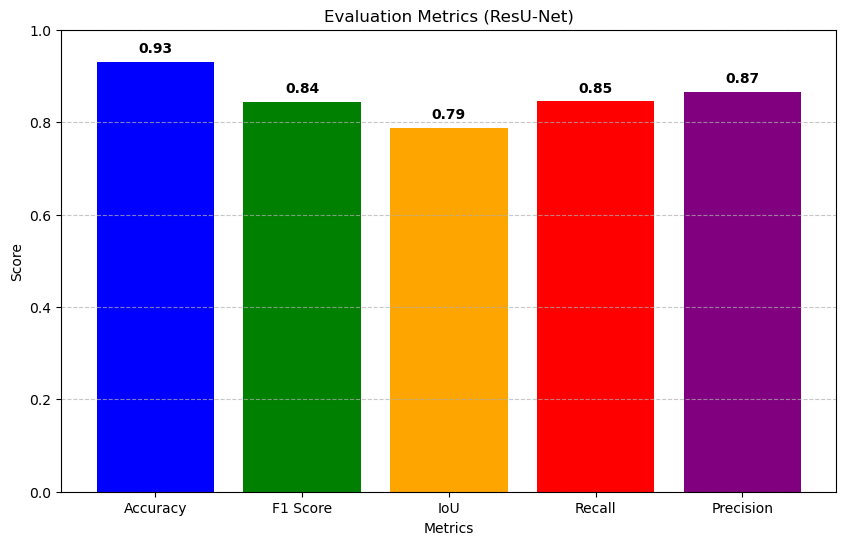

In [9]:
# 📌 Visualization of evaluation metrics
import matplotlib.pyplot as plt

# Extract mean values from previously computed scores
metrics = ["Accuracy", "F1 Score", "IoU", "Recall", "Precision"]
values = mean_scores

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.ylim(0, 1)
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Evaluation Metrics (ResU-Net)")

# Annotate bars with values
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10, fontweight='bold')

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



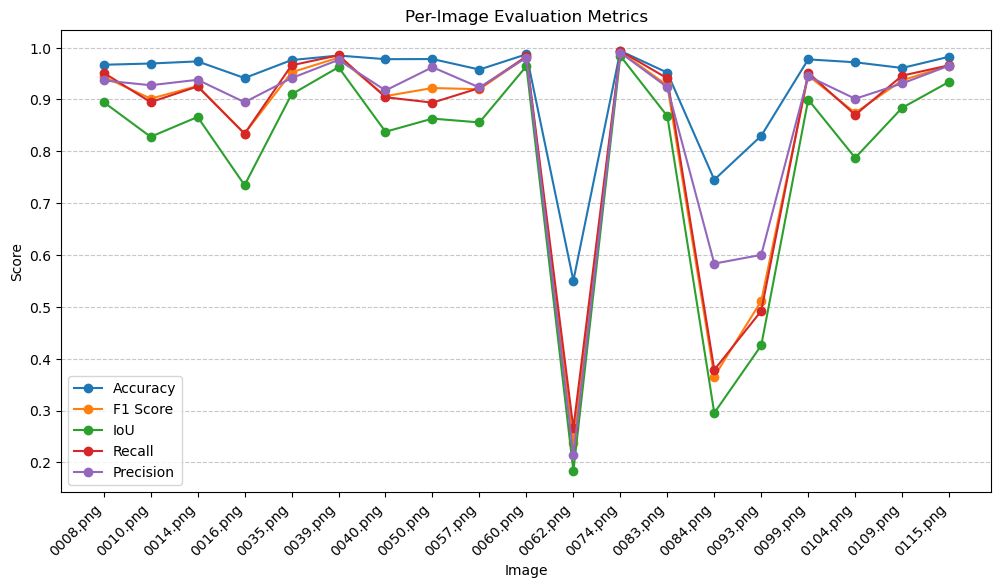

/tmp/ipykernel_9441/1045777730.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['Image'], rotation=45, ha="right")
/tmp/ipykernel_9441/1045777730.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['Image'], rotation=45, ha="right")
/tmp/ipykernel_9441/1045777730.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['Image'], rotation=45, ha="right")
/tmp/ipykernel_9441/1045777730.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['Image'], rotation=45, ha="right")
/tmp/ipykernel_9441/1045777730.py:41: UserWarning: set_ticklabels() should only be used with a fixed

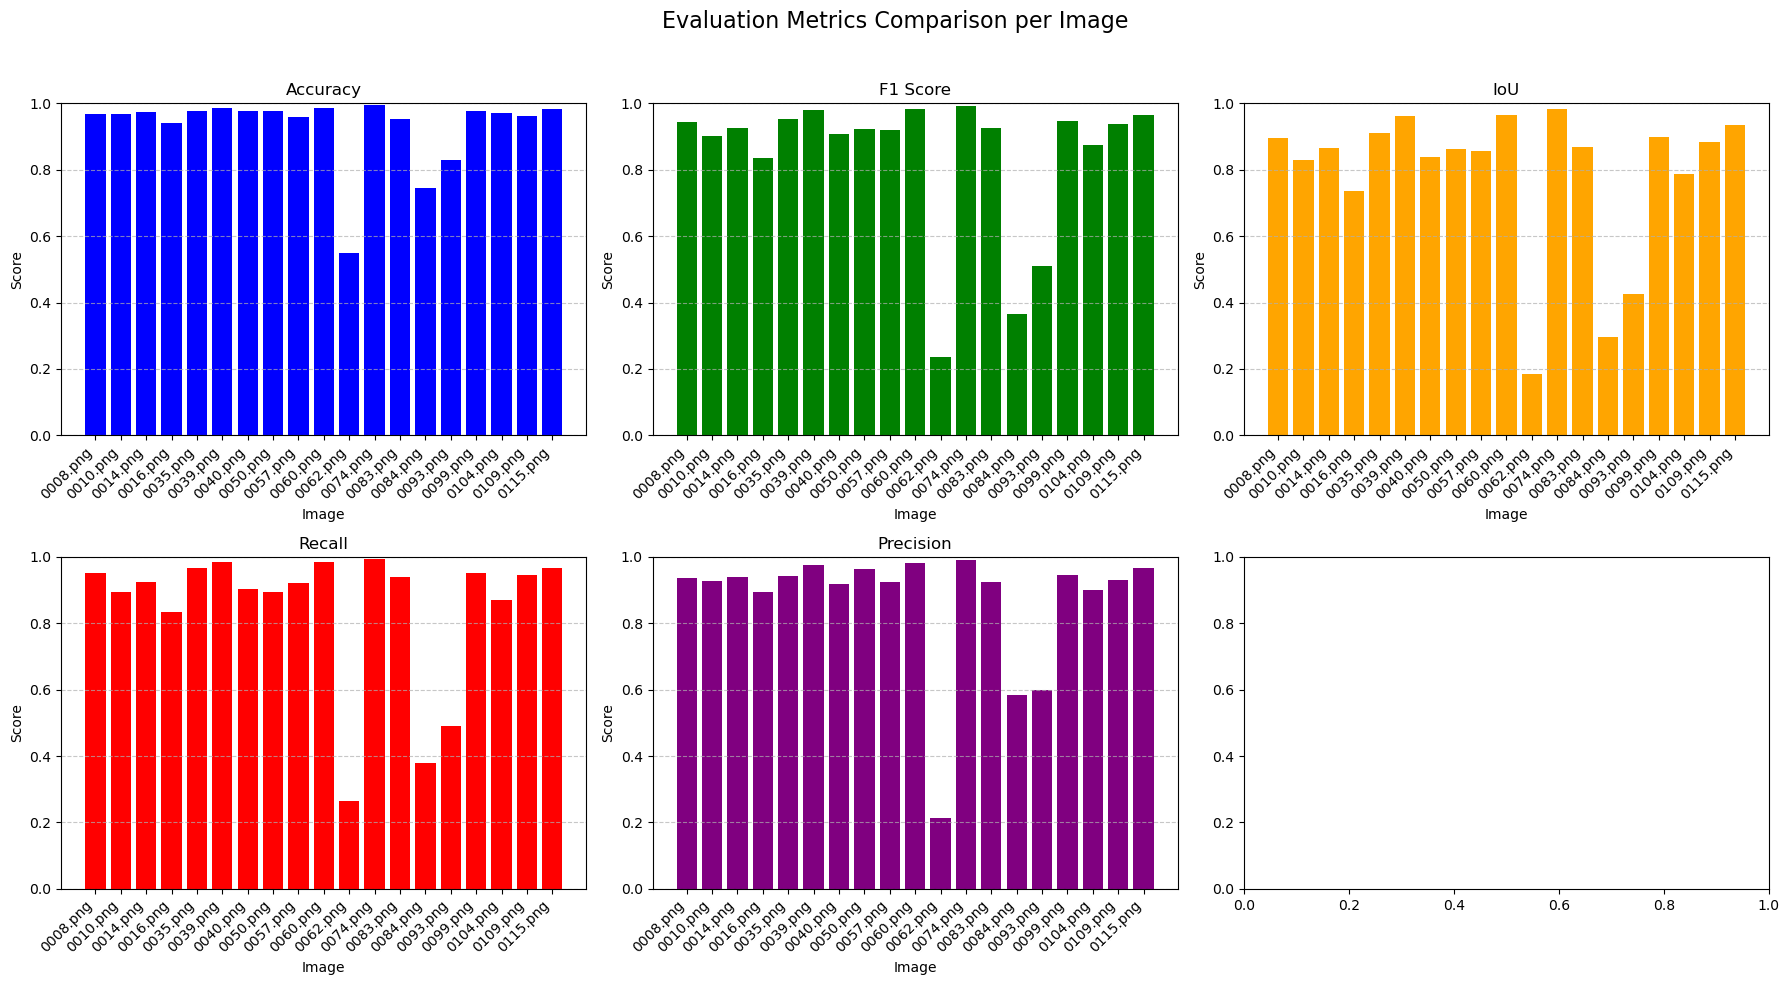

In [9]:
import pandas as pd

# Load the evaluation results CSV
csv_path = "/home/ahsan/University/Thesis/UNet_Directory/Datasets/second_phase/files/ResUnet/evaluation_results_resunet.csv"
df = pd.read_csv(csv_path)

# Remove the last row (mean metrics) for individual visualization
df = df.drop(df.index[-1])

# Convert data to numeric (excluding the 'Image' column)
df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)

# Plot line graph for metrics across images
plt.figure(figsize=(12, 6))

for metric in df.columns[1:]:
    plt.plot(df['Image'], df[metric], marker='o', label=metric)

plt.xlabel("Image")
plt.ylabel("Score")
plt.title("Per-Image Evaluation Metrics")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Create subplots for bar charts
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Evaluation Metrics Comparison per Image", fontsize=16)

metrics = ["Accuracy", "F1 Score", "IoU", "Recall", "Precision"]
colors = ['blue', 'green', 'orange', 'red', 'purple']

for i, metric in enumerate(metrics):
    ax = axs[i // 3, i % 3]
    ax.bar(df['Image'], df[metric], color=colors[i])
    ax.set_title(metric)
    ax.set_xlabel("Image")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.set_xticklabels(df['Image'], rotation=45, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


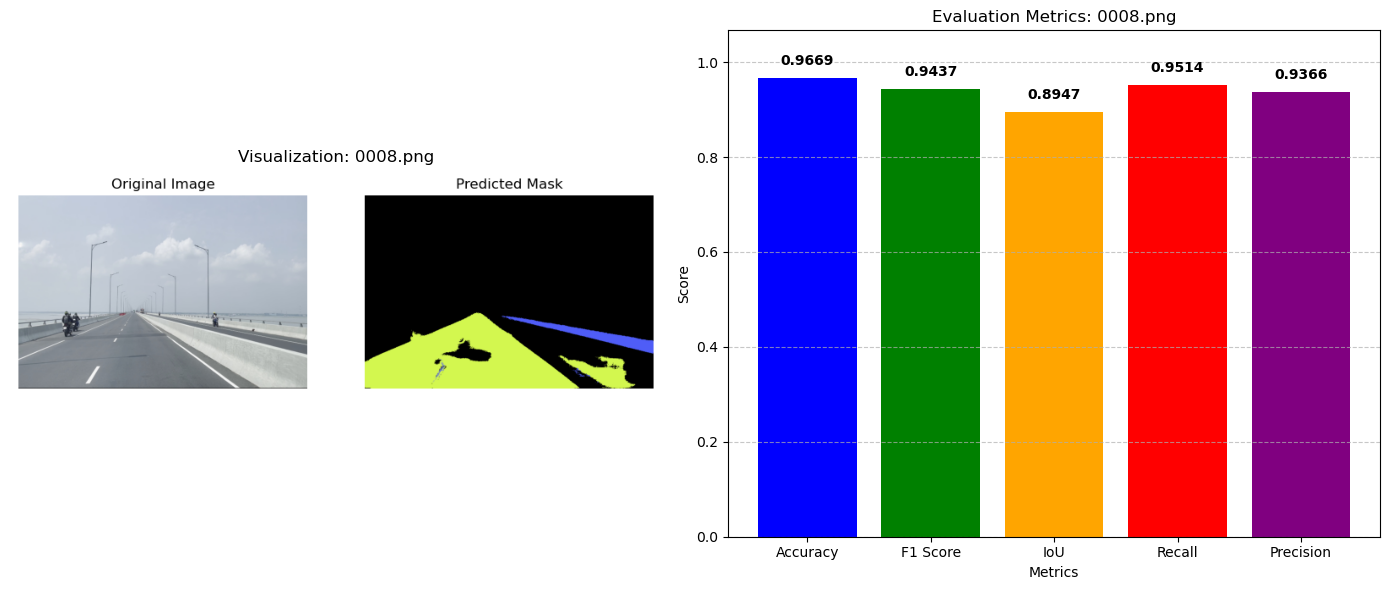

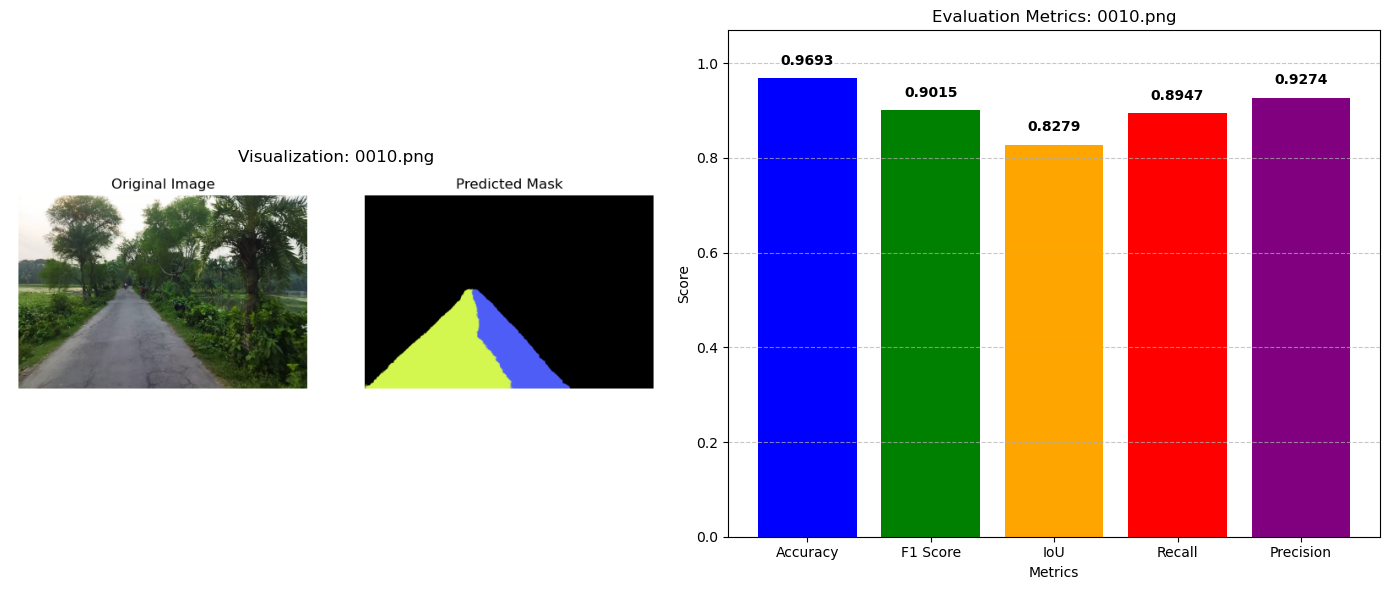

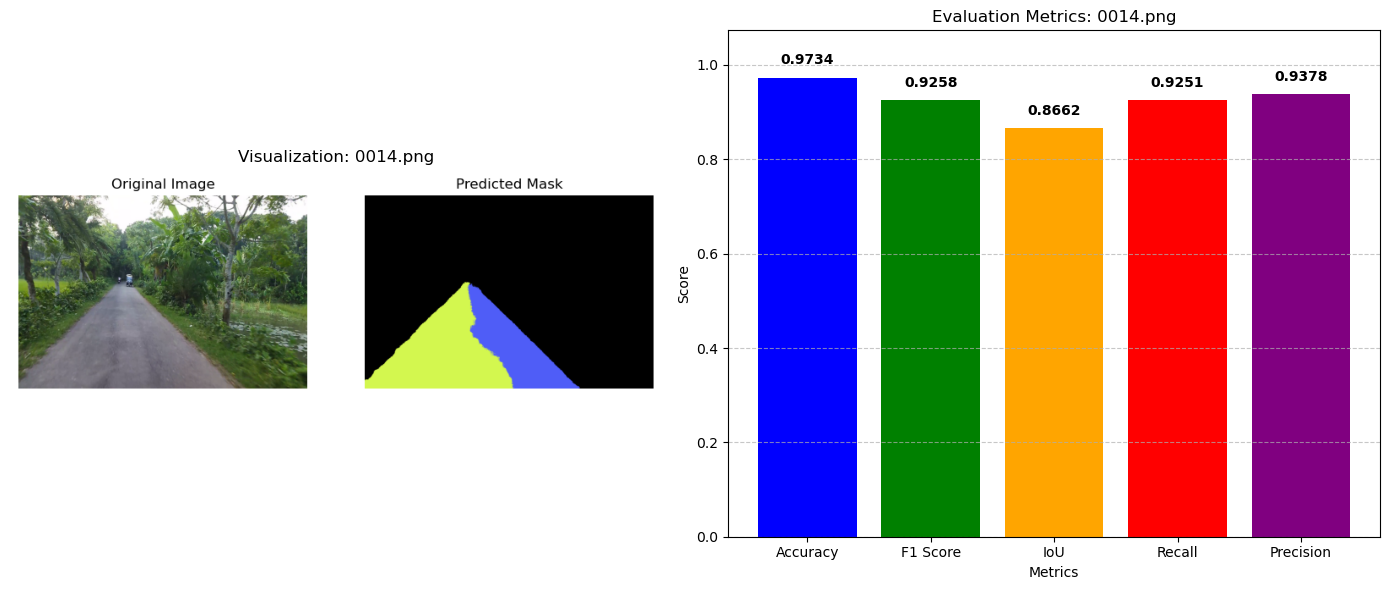

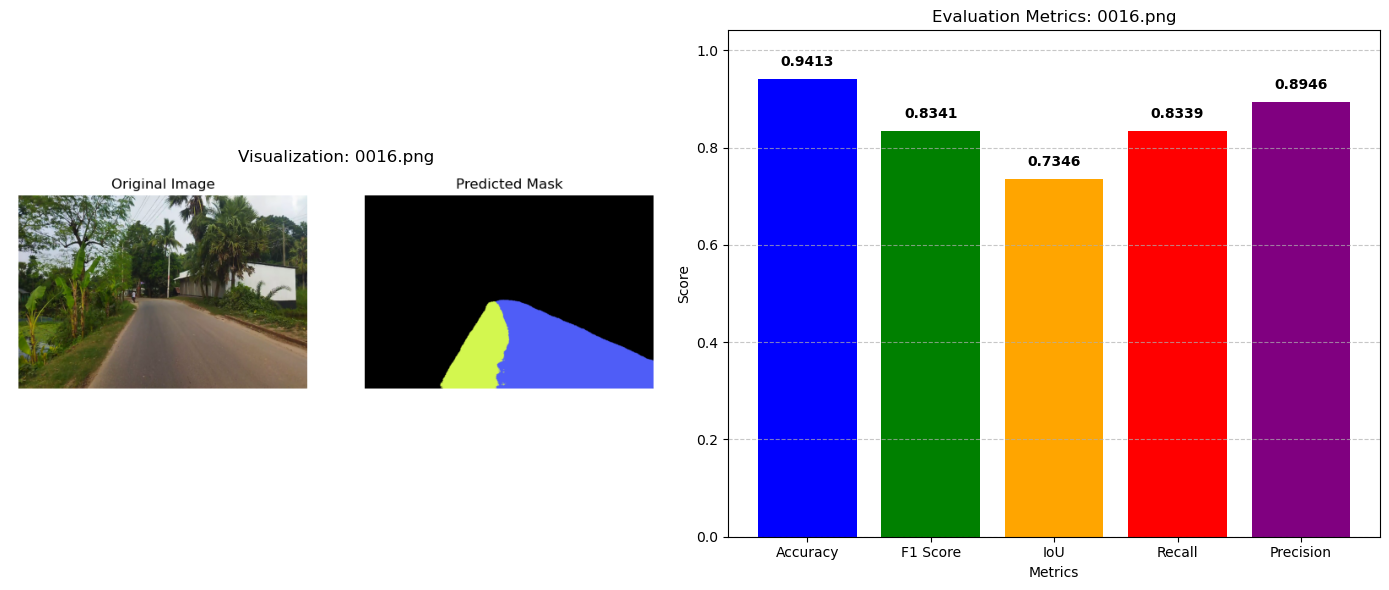

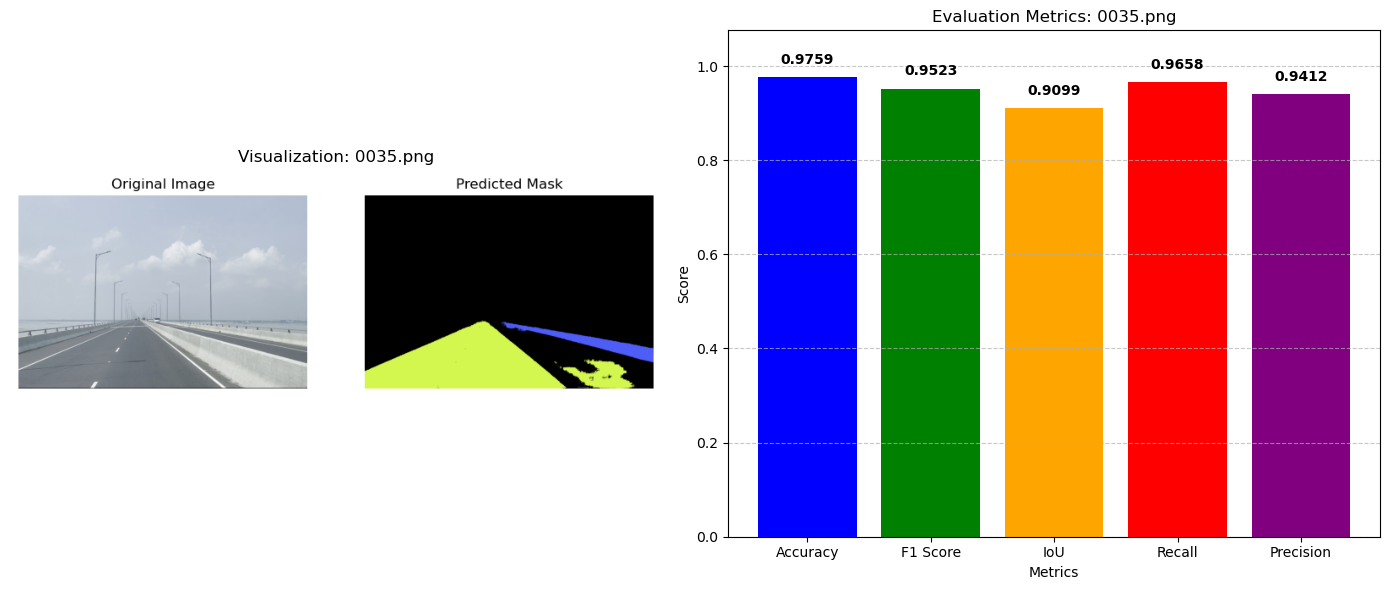

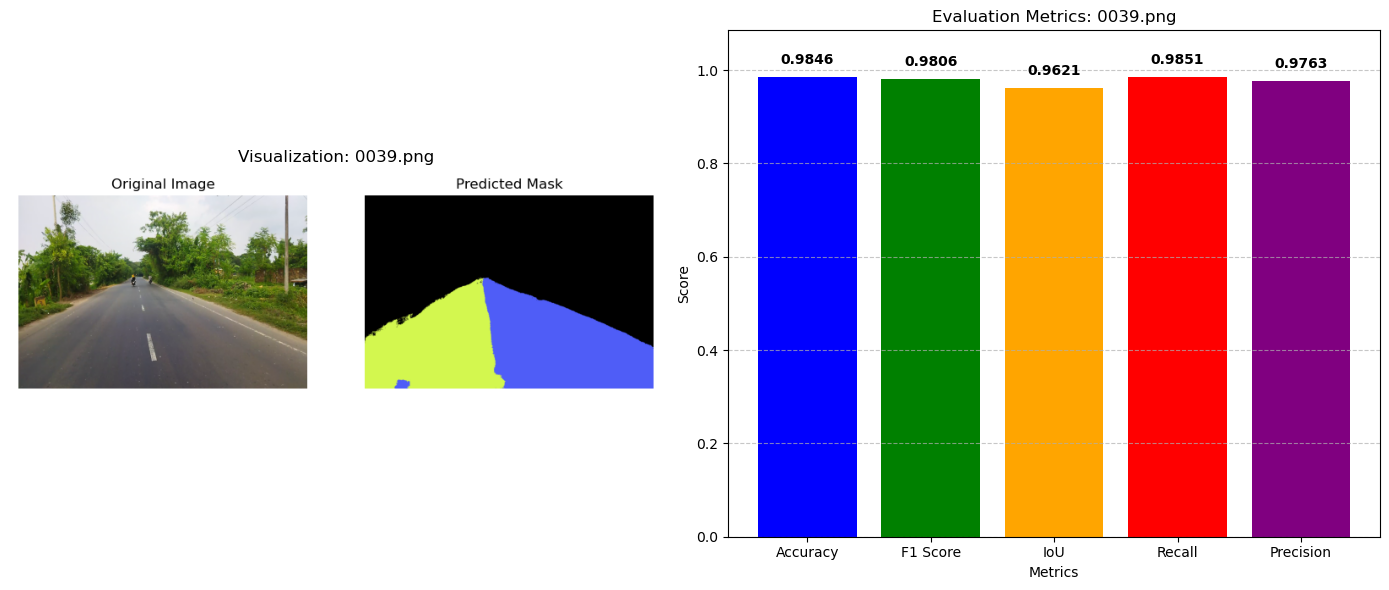

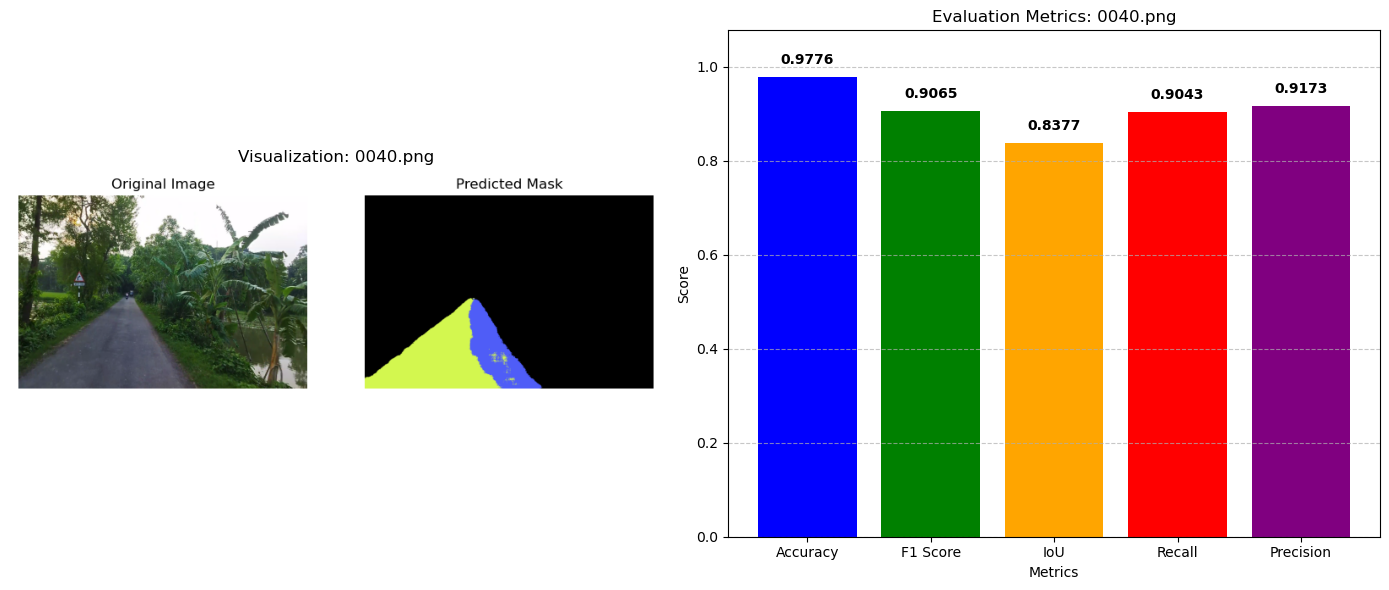

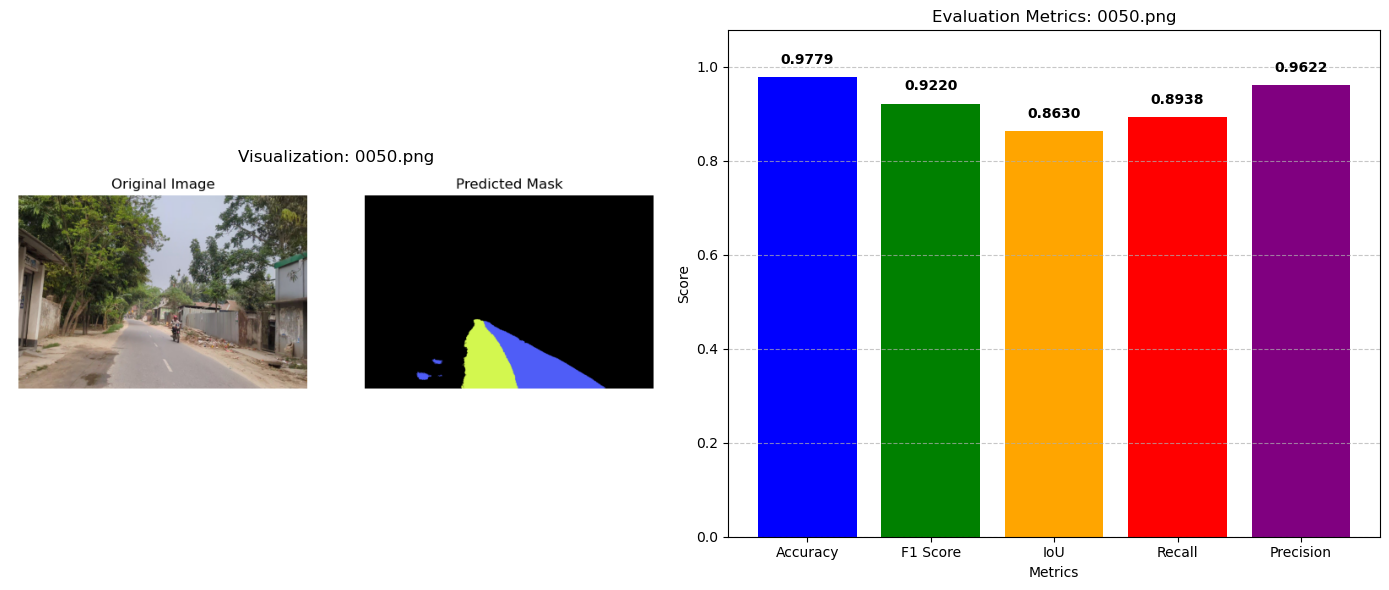

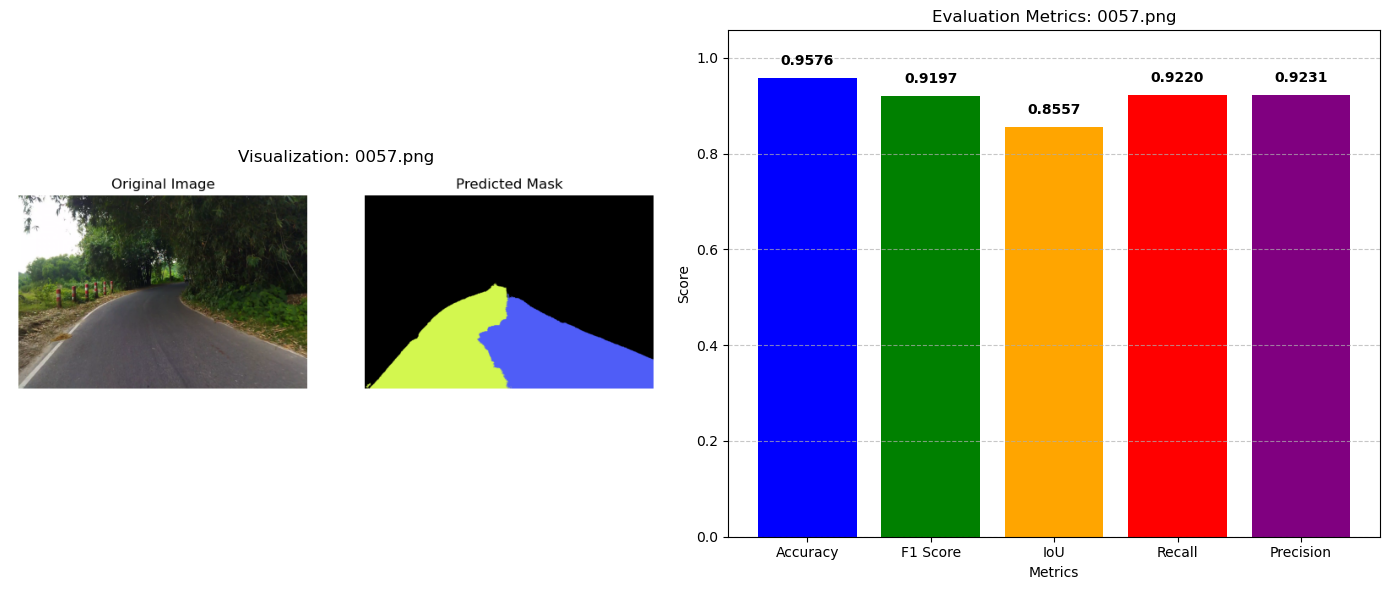

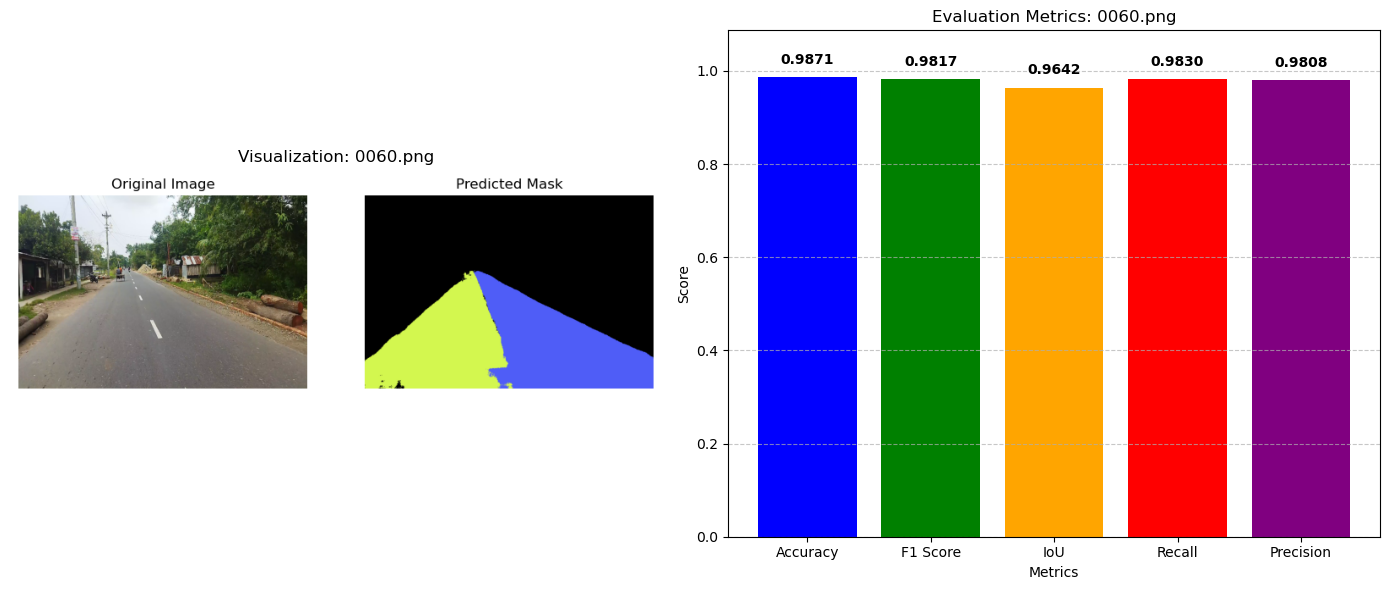

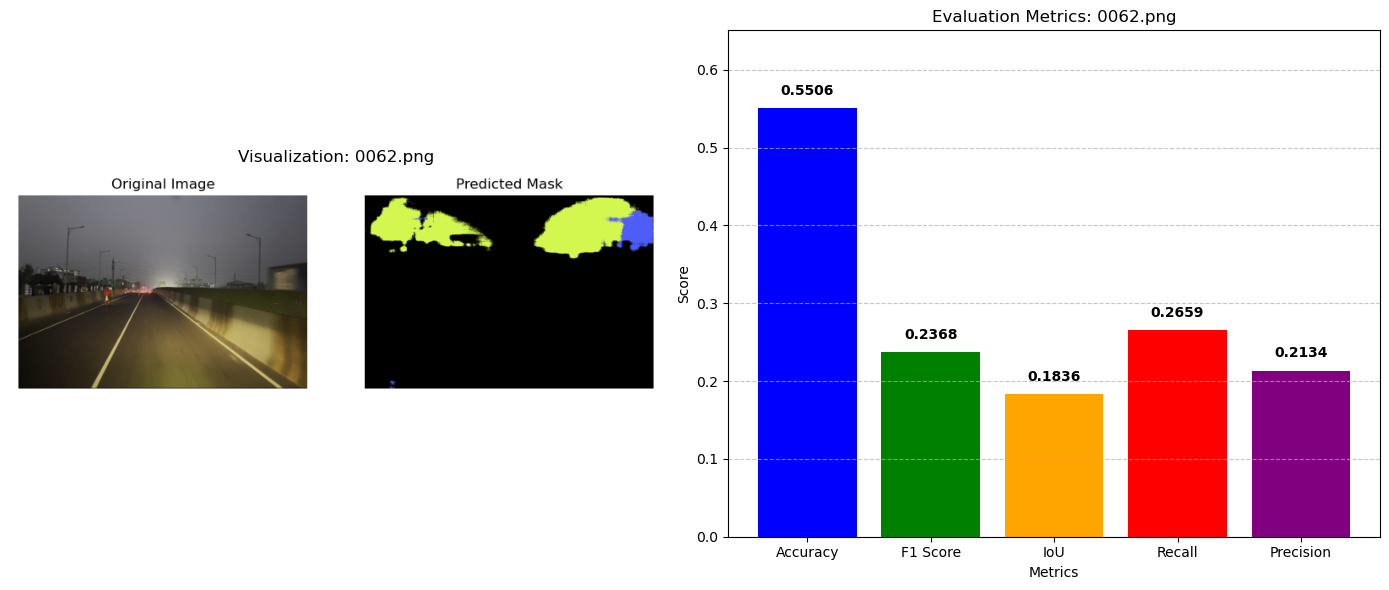

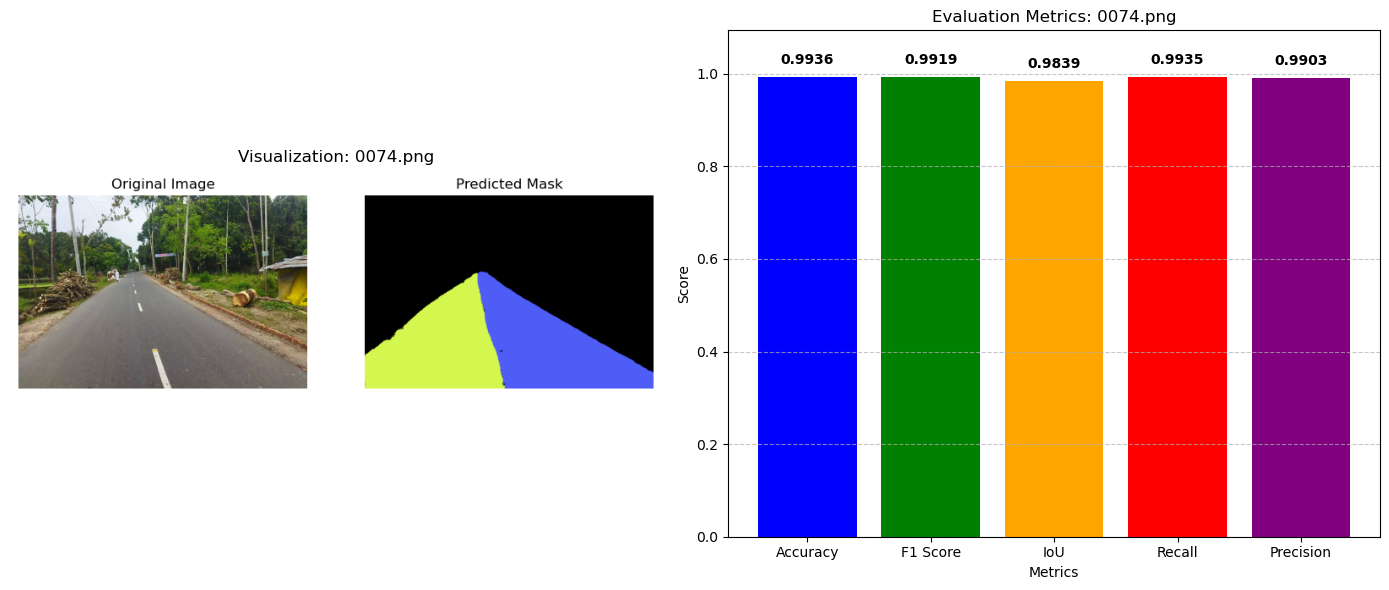

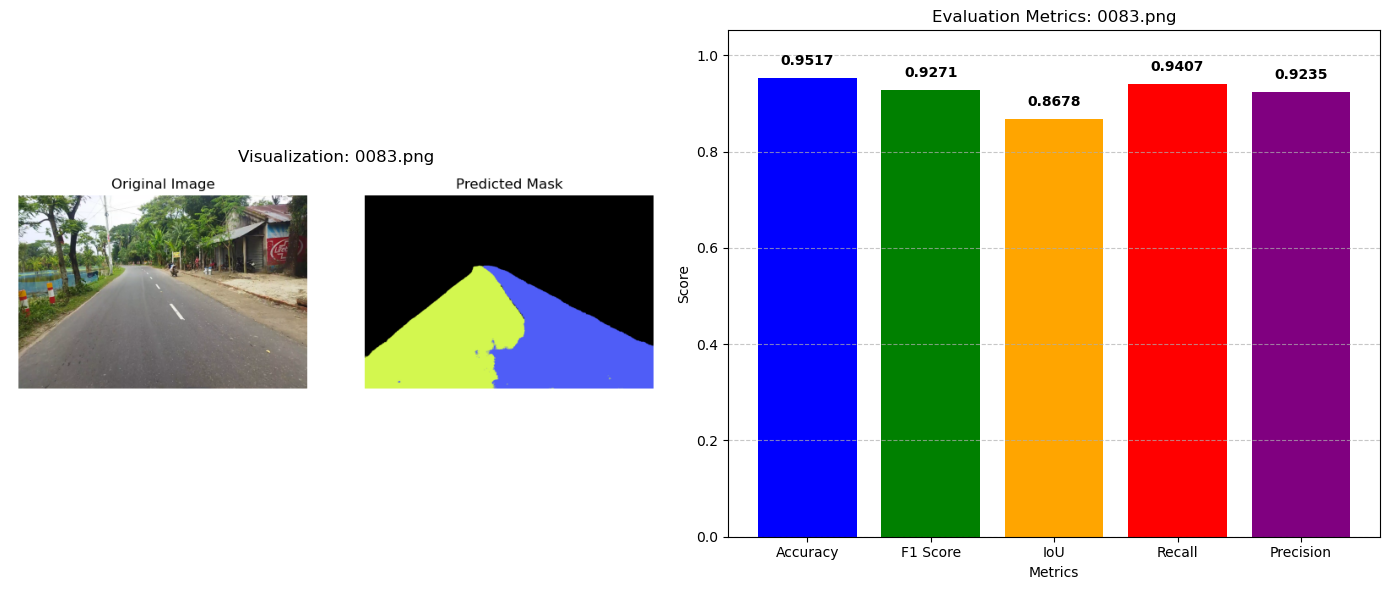

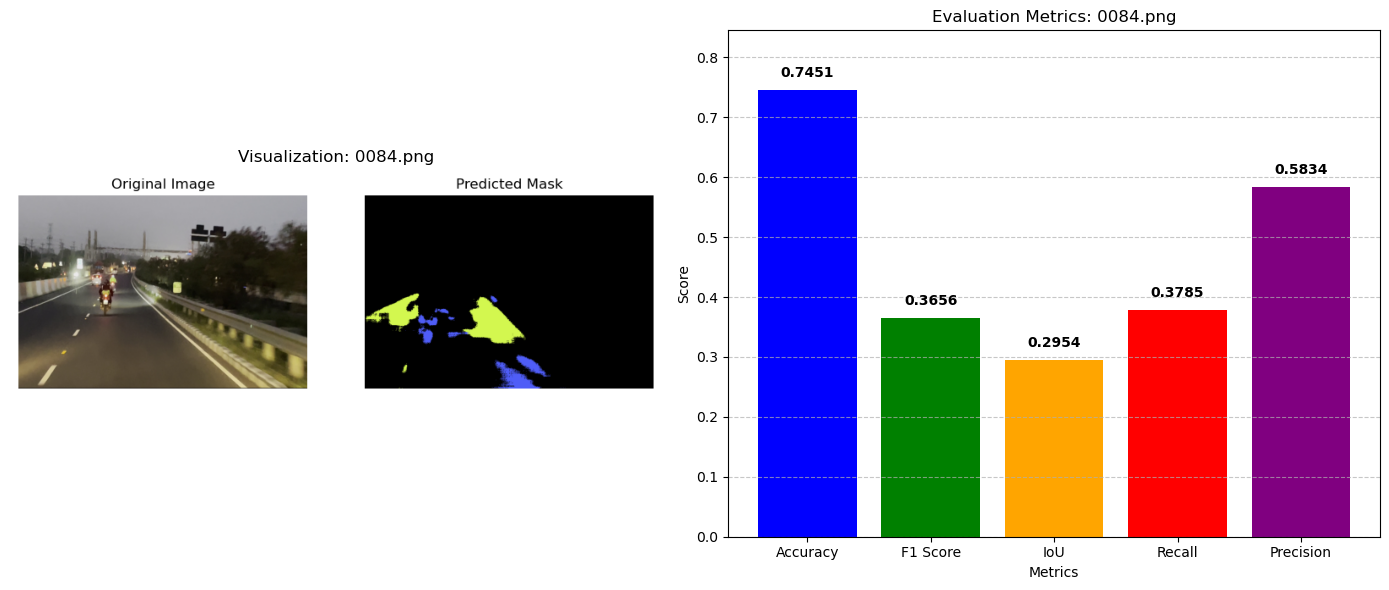

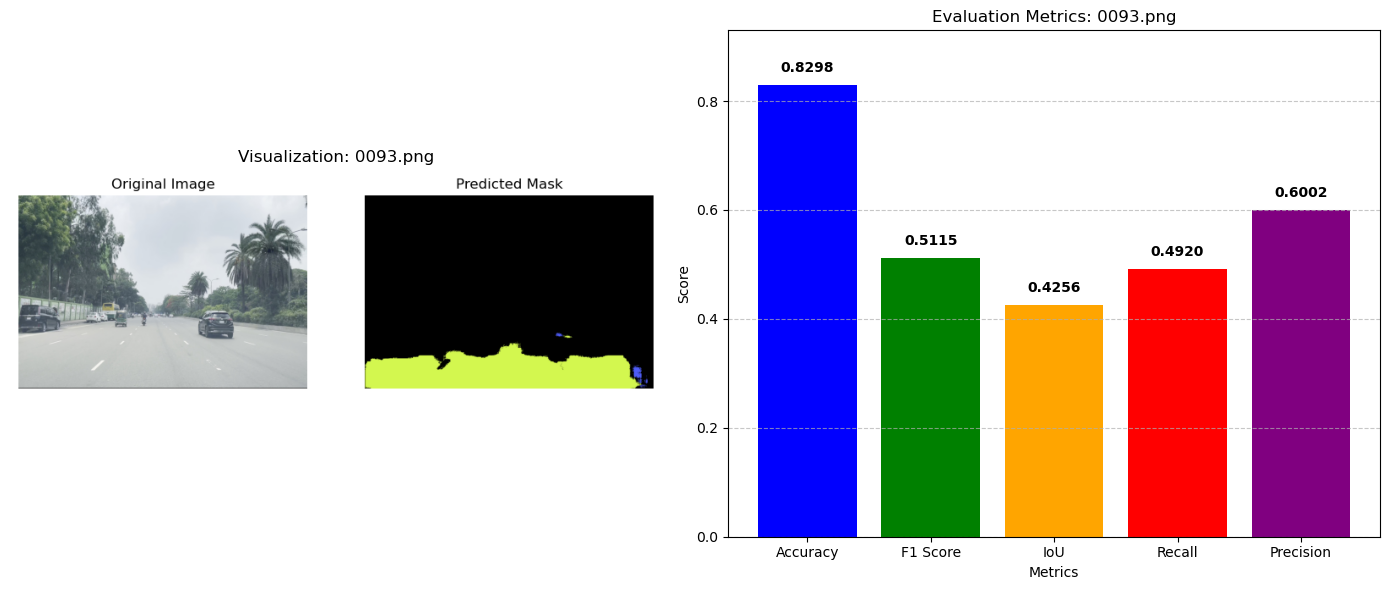

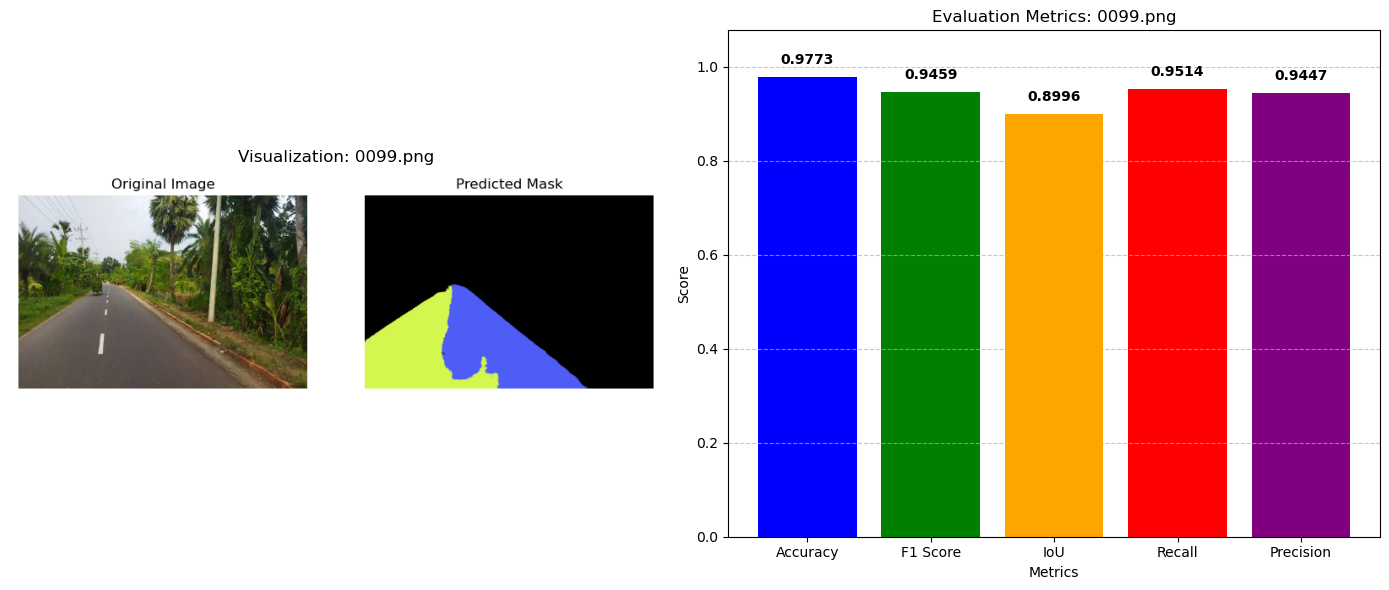

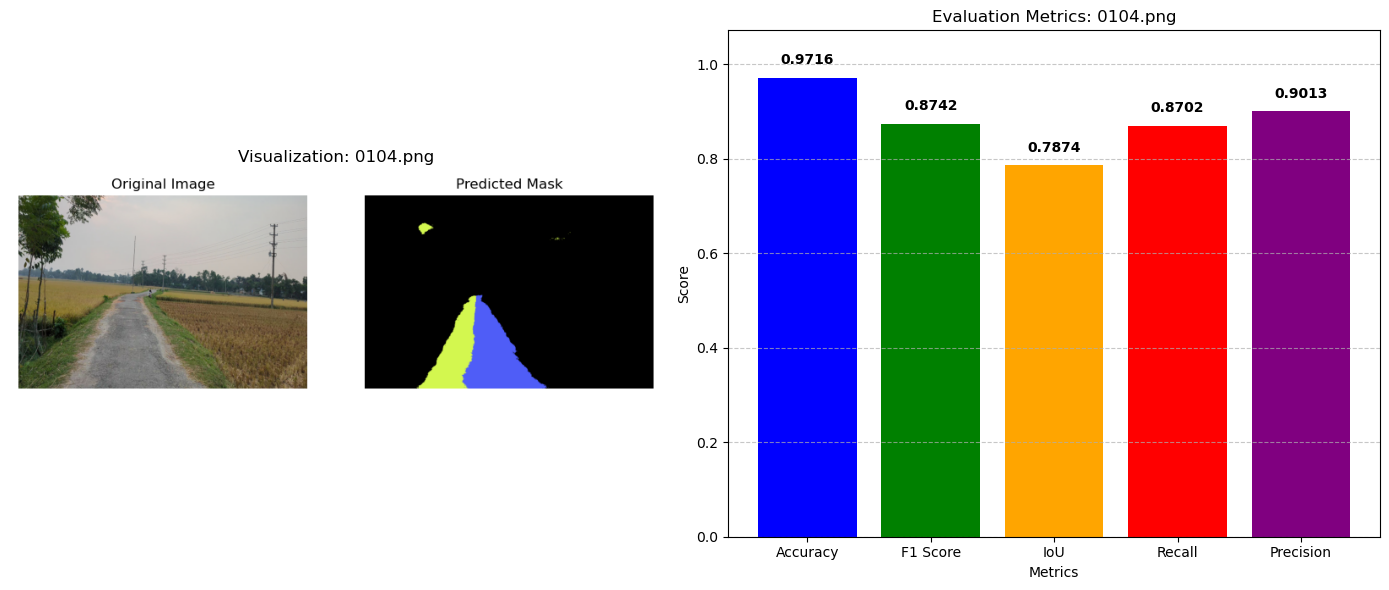

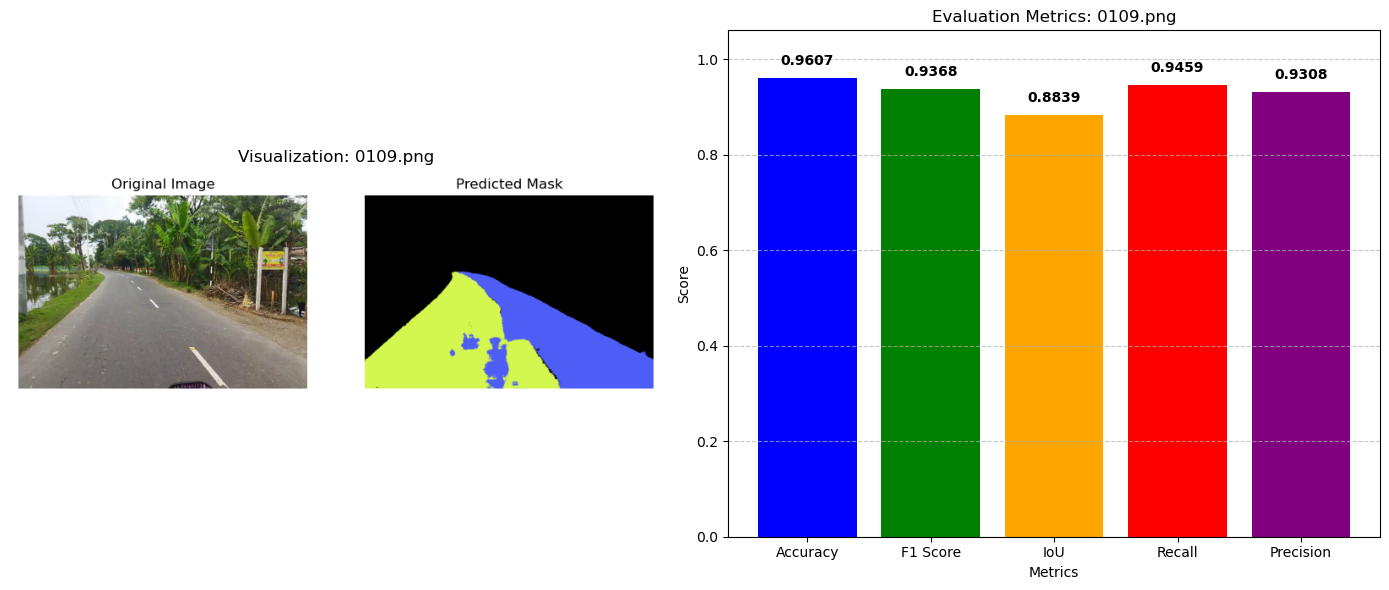

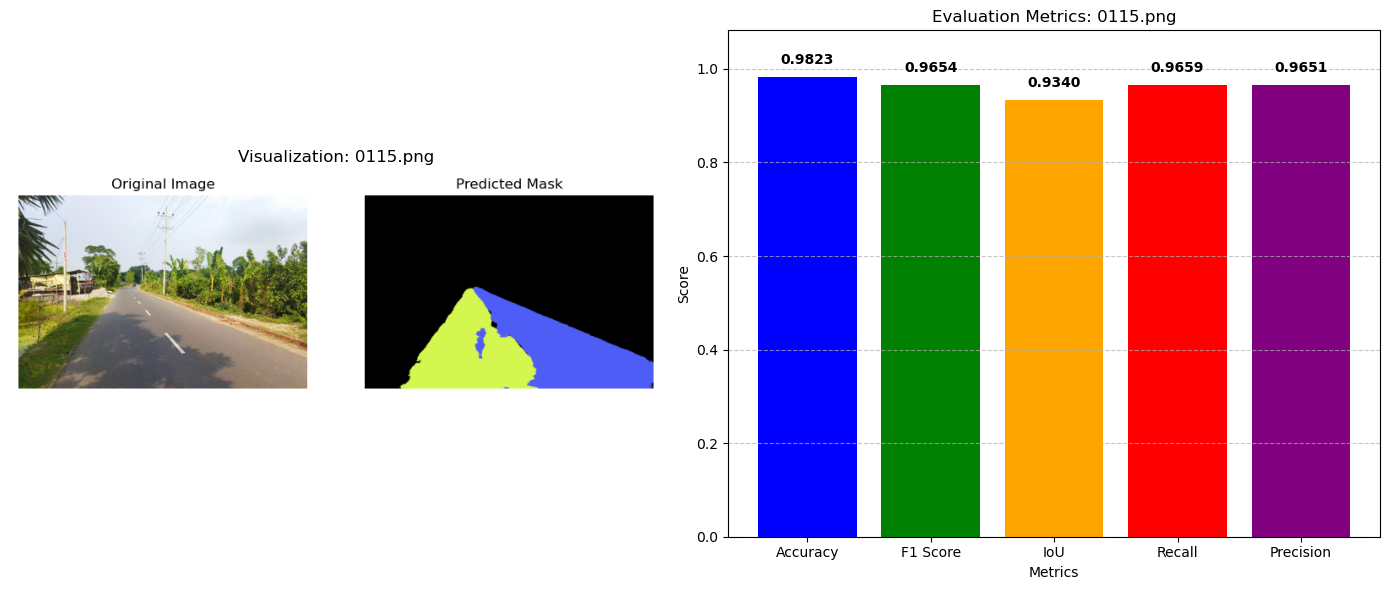

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Load evaluation results
csv_path = "/home/ahsan/University/Thesis/UNet_Directory/Datasets/second_phase/files/ResUnet/evaluation_results_resunet.csv"
df = pd.read_csv(csv_path)

# Remove the last row (mean metrics) for individual visualization
df = df.drop(df.index[-1])

# Convert data to numeric (excluding the 'Image' column)
df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)

# Visualization directory
visualization_dir = "/home/ahsan/University/Thesis/UNet_Directory/Datasets/second_phase/visulaize_side_by_side/ResUnet"

# Iterate through each row to visualize
for idx, row in df.iterrows():
    image_name = row["Image"]
    metric_values = row.iloc[1:].values
    metrics = df.columns[1:]

    # Load the corresponding visualization image
    vis_image_path = os.path.join(visualization_dir, image_name)
    vis_image = Image.open(vis_image_path)

    # Create a figure for visualization
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Show the saved visualization
    ax[0].imshow(vis_image)
    ax[0].axis("off")
    ax[0].set_title(f"Visualization: {image_name}")

    # Determine a dynamic y-axis limit with a margin
    max_value = max(metric_values)
    y_limit = max_value + 0.1 if max_value < 1 else max_value * 1.05  # Adjust if values are close to 1

    # Plot the evaluation metrics for this image with values on bars
    bars = ax[1].bar(metrics, metric_values, color=['blue', 'green', 'orange', 'red', 'purple'])
    ax[1].set_ylim(0, y_limit)
    ax[1].set_xlabel("Metrics")
    ax[1].set_ylabel("Score")
    ax[1].set_title(f"Evaluation Metrics: {image_name}")
    ax[1].grid(axis="y", linestyle="--", alpha=0.7)

    # Add value labels on top of each bar with slight offset
    for bar, value in zip(bars, metric_values):
        ax[1].text(
            bar.get_x() + bar.get_width() / 2,
            value + (y_limit * 0.02),  # Small margin to prevent overflow
            f"{value:.4f}",
            ha='center', va='bottom', fontsize=10, fontweight='bold'
        )

    plt.tight_layout()
    plt.show()
